### INSTALLING THE LIBRARIES NECESSARY FOR THE RL LEARNING ENVIRONMENT 

In [79]:
!pip install gymnasium matplotlib numpy

### IMPORTING THE REQUIRED LIBRARIES

In [80]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### CONSTRUCTING THE GRID USING MATPLOTLIB

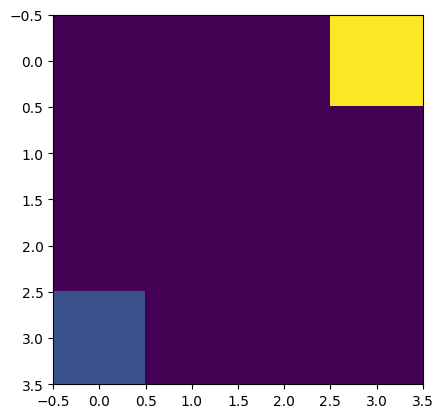

In [81]:
grid = np.zeros((4,4))
pos1 = [3,0]
pos2 = [0,3]
grid[tuple(pos1)] = 0.2
grid[tuple(pos2)] = 0.8
plt.imshow(grid)

#### DEFINING THE GRID ENVIRONMENT

In [82]:
# defining the grid class

class GridEnvironment(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 50
        self.timestep = 0
        self.reward = 0
        self.agent_pos = [3,0]
        self.goal_pos = [0,3]
        self.rock_pos1 = [2,3]
        self.rock_pos2 = [3,2]
        self.battery_pos1 = [0,0]
        self.battery_pos2 = [0,2]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.rock_pos1)] = 0.2
        self.state[tuple(self.rock_pos2)] = 0.2
        self.state[tuple(self.battery_pos1)] = 0.5
        self.state[tuple(self.battery_pos2)] = 0.5
    
    # reset function 
    def reset(self):
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.rock_pos1)] = 0.2
        self.state[tuple(self.rock_pos2)] = 0.2
        self.state[tuple(self.battery_pos1)] = 0.5
        self.state[tuple(self.battery_pos2)] = 0.5
        observation = self.state.flatten()
        info = {}
        return observation, info
    
    # step function 
    def step(self, action):
        if action == 0: # down
            self.agent_pos[0] += 1
        elif action == 1: # up
            self.agent_pos[0] -= 1
        elif action == 2: # right
            self.agent_pos[1] += 1
        elif action == 3: # left
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.rock_pos1)] = 0.2
        self.state[tuple(self.rock_pos2)] = 0.2
        self.state[tuple(self.battery_pos1)] = 0.5
        self.state[tuple(self.battery_pos2)] = 0.5
        observation = self.state.flatten()

        # reward = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
            self.reward += 10
        elif np.array_equal(self.agent_pos, self.rock_pos1):
            self.reward -= 5
        elif np.array_equal(self.agent_pos, self.rock_pos2):
            self.reward -= 6
        elif np.array_equal(self.agent_pos, self.battery_pos1):
            self.reward += 5
        elif np.array_equal(self.agent_pos, self.battery_pos2):
            self.reward += 6
        
        self.timestep += 1
        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = True if np.all((self.agent_pos >= 0) & (self.goal_pos) <= 2) else False
        info = {}
        return observation, self.reward, terminated, truncated, info
    
    def render(self):
        plt.title('Grid Environment')
        # plt.legend()
        plt.imshow(self.state)
        


#### CHECKING THE ENVIRONMENT FOR 2 DIFFERENT ENVIRONMENTS

#### FIRST ENVIRONMENT

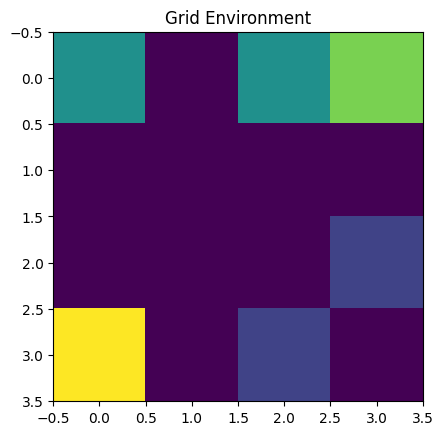

In [83]:
env = GridEnvironment()
terminated, truncated = False, False
observation, info = env.reset()
env.render()

#### SECOND ENVIRONMENT

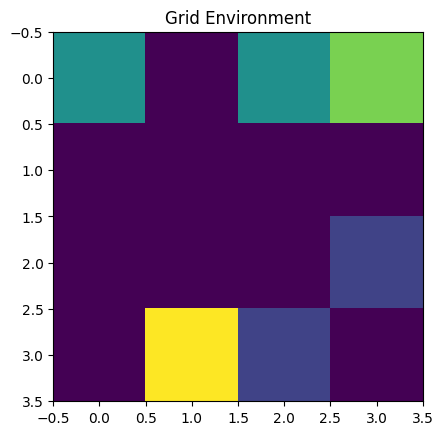

In [84]:
action = 2
observation, reward, terminated, truncated, info = env.step(action)
env.render()

#### DEFINING THE RANDOM AGENT TO TEST THE ENVIRONMENT

In [85]:
# random agent class 
class RandomAgent:
    def __init__(self, env):
        # env setting
        self.env = env
        # observation sapce 
        self.observation_space = env.observation_space
        # defining the action space 
        self.action_space = env.action_space
    
    def step(self, observation):
        # step function 
        return np.random.choice(self.action_space.n)

#### CHECKING WITH THE AGENT 

Action: 2, Reward: 0, completed: False
Action: 2, Reward: -6, completed: False
Action: 1, Reward: -6, completed: False
Action: 0, Reward: -12, completed: False
Action: 1, Reward: -12, completed: False
Action: 3, Reward: -12, completed: False
Action: 0, Reward: -12, completed: False
Action: 0, Reward: -12, completed: False
Action: 3, Reward: -12, completed: False
Action: 3, Reward: -12, completed: False
Action: 2, Reward: -12, completed: False
Action: 2, Reward: -18, completed: False
Action: 3, Reward: -18, completed: False
Action: 3, Reward: -18, completed: False
Action: 1, Reward: -18, completed: False
Action: 1, Reward: -18, completed: False
Action: 1, Reward: -13, completed: False
Action: 2, Reward: -13, completed: False
Action: 3, Reward: -8, completed: False
Action: 3, Reward: -3, completed: False
Action: 1, Reward: 2, completed: False
Action: 3, Reward: 7, completed: False
Action: 2, Reward: 7, completed: False
Action: 0, Reward: 7, completed: False
Action: 3, Reward: 7, complete

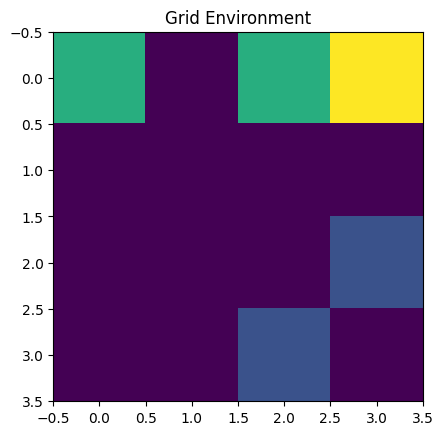

In [86]:

# checking with the agent luntil the  goal is reached or terminated due to crossing the boundaries of the grid
env = GridEnvironment()
agent = RandomAgent(env)
observation, info = env.reset()
terminated, truncated = False, False
# checking the termination condition 
while not terminated:
    # step function 
    action = agent.step(observation)
    # getting the observation , reward and termination function for each step  
    observation, reward, terminated, truncated, info = env.step(action)
    print(f'Action: {action}, Reward: {reward}, completed: {terminated}')
    env.render()

#### IMPLEMENTING SARSAC ALGORITHM

#### DEFINING THE SARSA Agent
  - Initalisating the hypeparameter values  
  -  taking aplha , gamma and epsilon hyperparameters . 
  - definign the choose action method 
  - epsilon represents the exploration rate , the cutoff until which the algorithm should learn. 

  - action_function method is used to do the exploration exploitation trade off
  - If the random number that is generated is less than current epsilon value  ,
       explore else take the maximum of already explored  
  -update q table ( update_q_table is used to store the current state and learned q values for all the 4 actions)
     at every state q table is populated . for current environment the q table is a 16 * 4 matrix. where 16  represents the total states and 4 actions  
  


In [87]:
from collections import defaultdict


class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1 , epsilon_decay=0.995):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.total_rewards = []
        self.epsilon_decay = epsilon_decay
    
    # exploration - explotation trade off - the learning algorithm 
    def action_function(self, state):
        state_tuple = tuple(state)
        if np.random.rand() >  self.epsilon:
            return np.argmax(self.q_table[state_tuple])
        else:
            return np.random.choice(self.env.action_space.n)
            
        
    # updating the q table 

    def update_q_table(self, next_state, next_action , reward , action , state):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        self.q_table[state_tuple][action] = self.alpha * (reward + self.gamma * (self.q_table[next_state_tuple][next_action]) - (self.q_table[state_tuple][action])) + self.q_table[state_tuple][action] 

    # decay epsilon function code. 
    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay 
        


#### defining sarsa_execution function  

In [88]:
# defining the function 
def sarsa_execution(env, agent, num_episodes=2000):
    for episode in range(num_episodes):
        state, _ = env.reset()
        action = agent.action_function(state)
        total_reward = 0
        completed = False
        while not completed:
            # if the agent is not reached the final destination do the env,step()
            next_state, reward, completed, _ , _3 = env.step(action)
            next_action = agent.action_function(next_state)
            # updating teh q table 
            agent.update_q_table(next_state, next_action ,  reward , action , state)
            state = next_state
            action = next_action
            # print(reward, end=" ")
            total_reward += reward
        # append the rewards to draw the graph. 
        agent.total_rewards.append(total_reward)
    print(agent.total_rewards)
    return agent.q_table

#### executing the agent , by defining the agent values 

In [89]:
env = GridEnvironment()
agent = SARSAAgent(env , 0.1 , 0.9 , 0.3)

# Inital q table before tarining 
for state, actions in agent.q_table.items():
    print(f"State -  {state}: {actions}")

# Run SARSA for training
q_table = sarsa_execution(env, agent, num_episodes=1000)

# Print the tarined  Q-table
print("Trained Q-table:")
for state, actions in q_table.items():
    print(f"State -  {state}: {actions}")


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6, -12, -12, -18, -18, -24, -24, -24, -29, -34, -34, -34, -34, -39, -39, -44, -44, -44, -50, -50, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -56, -62, -62, -62, -67, -67, -67, -61, -61, -61, -61, -61, -61, -56, -51, -51, -46, -46, -46, -46, -46, -46, -46, -46, -46, -36, -30, -20, -10, 0, 10, 20, 26, 32, 38, 48, 48, 48, 48, 48, 58, 68, 78, 88, 98, 108, 118, 128, 138, 138, 138, 138, 138, 148, 158, 168, 178, 188, 198, 208, 218, 228, 228, 228, 228, 228, 228, 228, 228, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 22

#### defining the functions to plot the graph , rewards and epsilon decay. 

In [90]:

# defining teh function to print q_table values 
def print_q_table(q_table):
    print("Q-table:")
    print(q_table)

# ploting the rewards 

def plot_rewards(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward per Episode')
    plt.title('Total Reward per Episode')
    plt.show()

# plotting the epsilon decay 

def plot_epsilon_decay(epsilon_values):
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay')
    plt.show()



#### Plot the total reward per episode graph
#### Plot the epsilon decay graph
- for increase in episode values there is increase in the rewards. 

Q-table:
defaultdict(<function SARSAAgent.__init__.<locals>.<lambda> at 0x7f777dfc85e0>, {(0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 1.0, 0.0, 0.2, 0.0): array([ 76.6145554 , 348.98617234, -11.144     ,  71.956     ]), (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): array([  65.884     ,  164.646     , 1327.25507626,   98.64572223]), (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 1.0, 0.2, 0.0): array([300.00158484,  -5.6       , 704.08668783, 171.0605354 ]), (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): array([ 169.51461179,   -6.1       ,  450.40112454, 1344.14982522]), (0.5, 0.0, 0.5, 0.8, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): array([ 75.01      ,  -6.1       ,  -4.6       , 393.63105324]), (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.2, 0.0, 0.0, 0.2, 0.0): array([2943.14128315,  -13.933     ,  797.6711977 ,  331.0975057 ]), (0.5, 0.0, 0.5, 

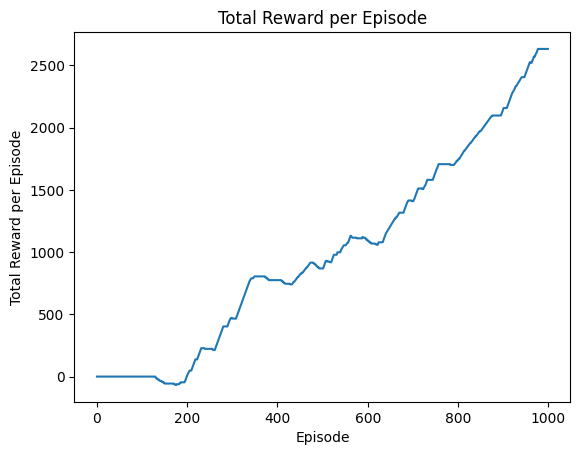

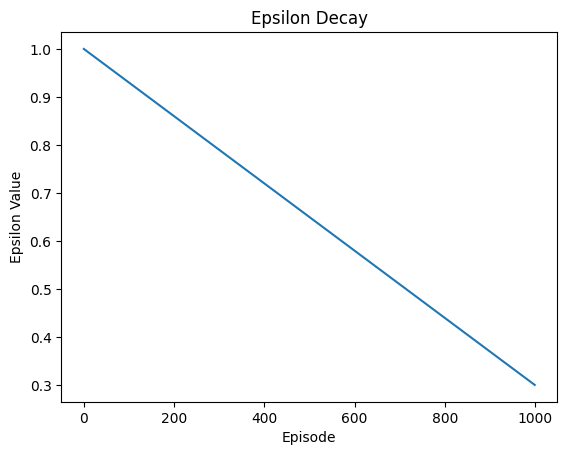

In [91]:

print_q_table(agent.q_table)
print(agent.total_rewards)
plot_rewards(agent.total_rewards)
plot_epsilon_decay(np.linspace(1.0, agent.epsilon, len(agent.total_rewards)))

#### In greedy SARS agent defination , this is extending the Agent class and changing the action_function 

In [92]:
class SARS_Greedy_Agent(SARSAAgent):
    def __init__(self, env, alpha=0.1, gamma=0.9):
        super().__init__(env, alpha, gamma, epsilon=0.0)

    def action_function(self, state):
        state_tuple = tuple(state)
        return np.argmax(self.q_table[state_tuple])


 #### defining and executing the SARS Greedy Agent.

In [93]:
greedy_agent = SARS_Greedy_Agent(env, 0.1, 0.9)
# executing with num episodes 10 
sarsa_execution(env, greedy_agent, num_episodes=10)
for state, actions in greedy_agent.q_table.items():
    print(f"State -  {state}: {actions}")

[2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628]
State -  (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): [262.8   0.    0.    0. ]
State -  (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): [262.8   0.    0.    0. ]
State -  (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 1.0): [2030.26943043    0.            0.            0.        ]


#### Printing the total rewards per episode and epsilon decay values 

Q-table:
defaultdict(<function SARSAAgent.__init__.<locals>.<lambda> at 0x7f777da9f490>, {(0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): array([262.8,   0. ,   0. ,   0. ]), (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0): array([262.8,   0. ,   0. ,   0. ]), (0.5, 0.0, 0.5, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 1.0): array([2030.26943043,    0.        ,    0.        ,    0.        ])})
[2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628]


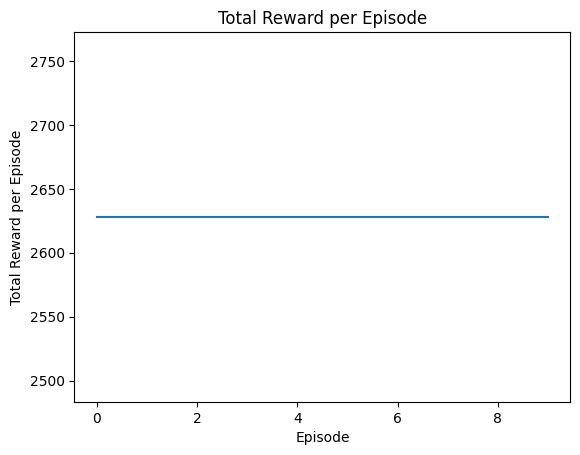

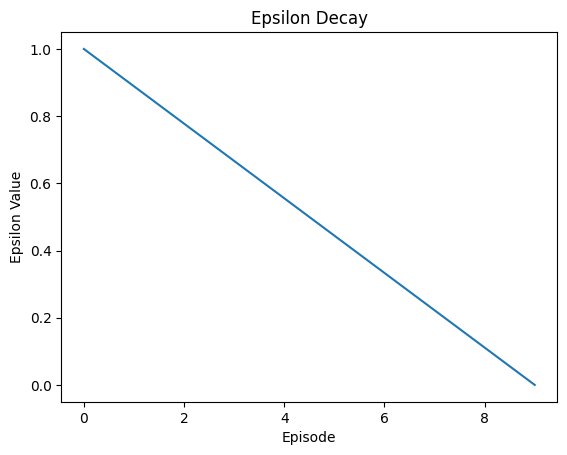

In [94]:
print_q_table(greedy_agent.q_table )
print(greedy_agent.total_rewards)
plot_rewards(greedy_agent.total_rewards)
plot_epsilon_decay(np.linspace(1.0, greedy_agent.epsilon, len(greedy_agent.total_rewards)))


In [95]:
# Manual Hyperparameter Tuning
hp_gamma_values = [0.2, 0.6, 0.95]
hp_epsilon_decay_values = [0.95, 0.99, 0.995]



Gamma: 0.2, Epsilon Decay: 0.95
[2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2628, 2623, 2623, 2618, 2618, 2618, 2618, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2613, 2607, 2601, 2595, 2589, 2583, 2577, 2571, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2565, 2559, 2553, 2547, 2541, 2535, 2529, 2523, 2517, 2511, 

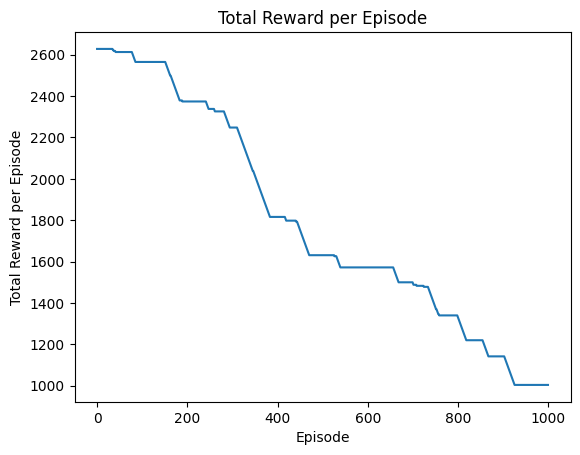


Gamma: 0.2, Epsilon Decay: 0.99
[1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 998, 992, 986, 980, 974, 968, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 962, 

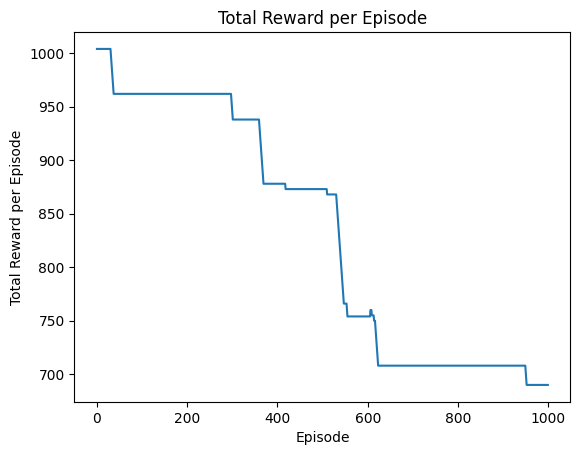


Gamma: 0.2, Epsilon Decay: 0.995
[690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 684, 678, 672, 666, 660, 654, 648, 642, 636, 630, 624, 618, 612, 606, 600, 594, 588, 582, 576, 570, 564, 558, 552, 546, 540, 534, 528, 522, 516, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 504, 498, 492, 486, 480, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 468, 462, 456, 450, 444, 438, 432, 426, 426, 420, 414, 408, 402, 396, 390, 384, 378, 372, 366, 360, 354, 348, 342, 336, 330, 324, 318, 312, 306, 300, 294, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 282, 276, 270, 264, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 

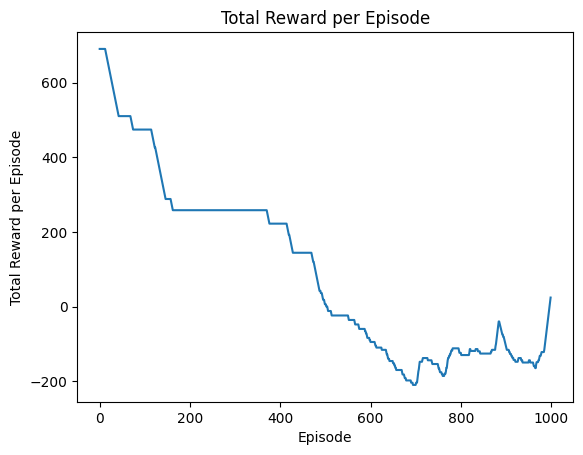


Gamma: 0.6, Epsilon Decay: 0.95
[24, 19, 19, 13, 7, 1, -5, -11, -11, -11, -11, -11, -17, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -29, -29, -29, -29, -29, -29, -29, -29, -35, -35, -40, -40, -40, -40, -46, -46, -46, -46, -46, -46, -46, -46, -46, -46, -46, -46, -46, -51, -51, -41, -31, -31, -36, -36, -42, -42, -42, -47, -47, -47, -47, -47, -47, -47, -41, -41, -41, -41, -41, -41, -41, -36, -31, -31, -31, -25, -19, -19, -19, -24, -24, -24, -24, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -30, -25, -25, -25, -19, -19, -14, -14, -9, -9, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -10, -16, -16, -22, -28, -28, -33, -33, -39, -39, -39, -39, -44, -44, -44, -44, -38, -28, -28, -18, -12, -12, -12, -12, -12, -12, -12, -12, -12, -12, -12, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -23, -23, -23, -23, -28, -28, -34, -34, -34, -34, -40, -40, -40, -40, -40, -40, -40, -40, -40, -30, -30, -35, -40, -40, 

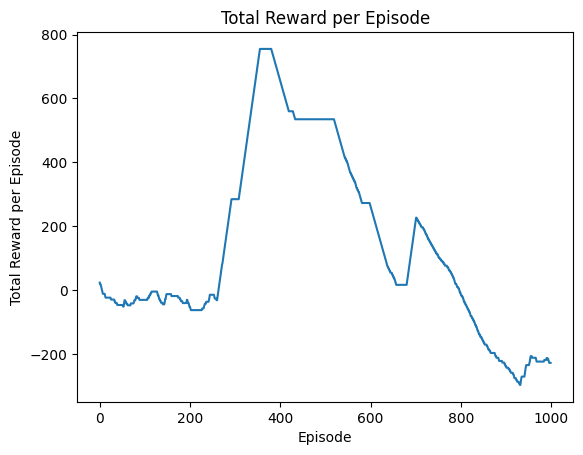


Gamma: 0.6, Epsilon Decay: 0.99
[-232, -232, -232, -237, -237, -227, -217, -211, -211, -211, -211, -211, -211, -211, -211, -211, -211, -205, -195, -195, -195, -195, -195, -201, -201, -201, -201, -201, -201, -195, -195, -190, -190, -190, -190, -190, -190, -185, -185, -185, -185, -185, -185, -185, -190, -190, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -180, -186, -186, -192, -192, -192, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -198, -193, -193, -187, -187, -187, -192, -192, -192, -186, -180, -180, -180, -185, -185, -191, -191, -191, -191, -196, -196, -196, -186, -186, -191, -191, -191, -191, -197, -197, -203, -203, -203, -203, -203, -198, -198, -198, -198, -198, -198, -198, -192, -192, -192, -192, -192, -192, -197, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -202, -196, -190, -190, -190, -190, -190, -190, 

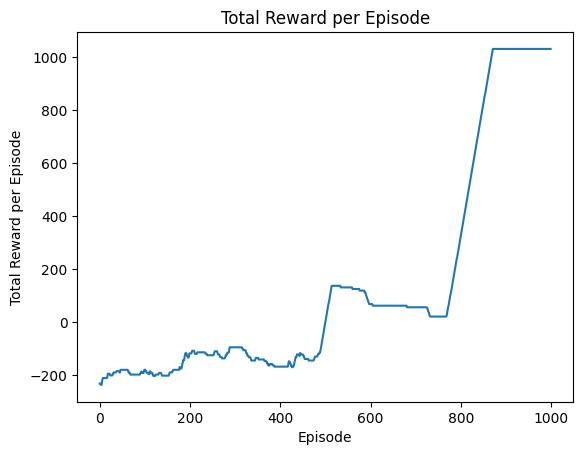


Gamma: 0.6, Epsilon Decay: 0.995
[1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031,

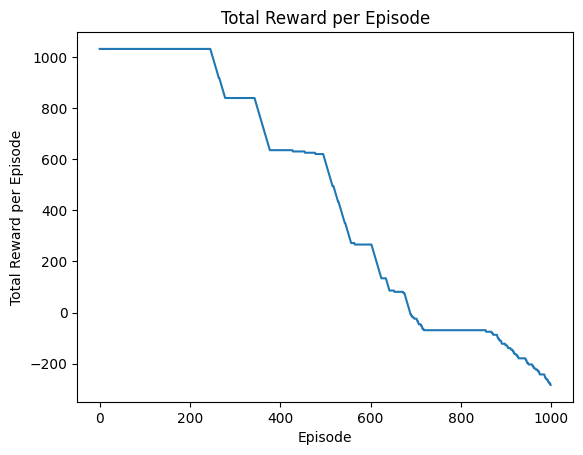


Gamma: 0.95, Epsilon Decay: 0.95
[-289, -289, -295, -295, -295, -300, -300, -300, -300, -305, -305, -305, -311, -311, -311, -311, -311, -311, -311, -311, -311, -317, -317, -322, -327, -327, -327, -321, -321, -321, -326, -326, -316, -310, -310, -310, -310, -310, -310, -310, -310, -310, -310, -310, -310, -310, -310, -305, -300, -300, -300, -294, -294, -289, -289, -289, -289, -289, -295, -295, -295, -295, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -301, -296, -291, -291, -286, -281, -281, -275, -269, -269, -269, -269, -269, -274, -274, -274, -274, -274, -274, -268, -258, -252, -252, -252, -252, -252, -252, -242, -236, -236, -236, -236, -236, -242, -242, -242, -242, -242, -247, -247, -252, -252, -258, -258, -258, -263, -263, -263, -263, -257, -257, -257, -257, -257, -257, -257, -257, -257, -257, -257, -247, -237, -227, -221, -221, -221, -227, -233, -233, -238, -243,

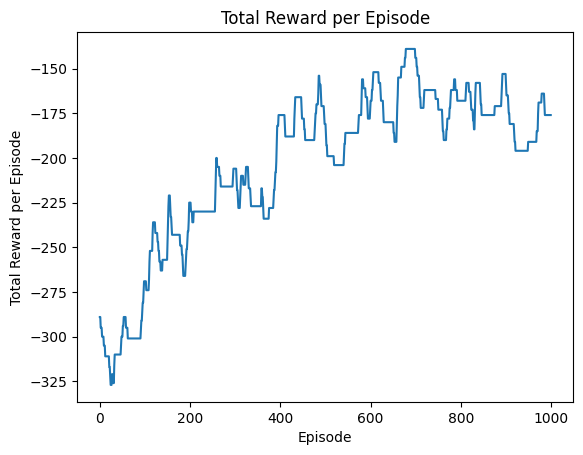


Gamma: 0.95, Epsilon Decay: 0.99
[-176, -176, -176, -176, -176, -176, -176, -182, -188, -188, -194, -194, -194, -194, -199, -199, -199, -199, -204, -204, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -210, -204, -194, -184, -178, -178, -178, -178, -178, -173, -168, -163, -163, -163, -163, -163, -163, -163, -163, -163, -163, -158, -158, -158, -158, -158, -158, -164, -164, -170, -170, -170, -170, -175, -175, -175, -175, -175, -180, -180, -186, -186, -186, -186, -191, -191, -181, -175, -175, -175, -175, -169, -163, -153, -153, -153, -153, -153, -153, -153, -153, -158, -158, -164, -164, -164, -164, -164, -164, -164, -164, -164, -164, -164, -164, -158, -152, -142, -136, -136, -130, -130, -130, -130, -135, -135, -125, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -115, -121, -121, -121, -121, -121, -115, -115, -110,

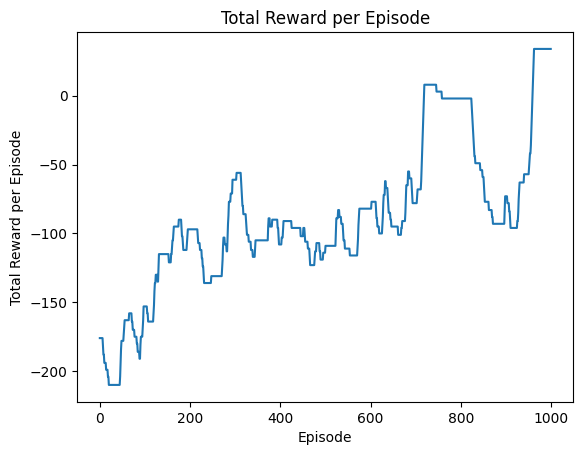


Gamma: 0.95, Epsilon Decay: 0.995
[29, 29, 29, 29, 29, 29, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 19, 19, 19, 19, 19, 19, 19, 19, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 9, 9, 9, 9, 9, 9, 3, -3, -3, -9, -15, -21, -27, -33, -39, -45, -45, -45, -45, -45, -51, -57, -57, -57, -57, -57, -62, -67, -67, -72, -72, -72, -72, -72, -72, -72, -72, -72, -72, -78, -84, -84, -84, -84, -84, -84, -84, -84, -84, -84, -84, -84, -84, -90, -90, -95, -95, -85, -79, -79, -79, -79, -79, -79, -74, -74, -74, -74, -74, -68, -62, -52, -52, -52, -52, -52, -52, -46, -46, -41, -36, -36, -31, -26, -26, -26, -26, -26, -31, -31, -36, -41, -41, -41, -41, -41, -41, -47, -47, -52, -52, -52, -52, -52, -52, -52, -58, -64, -64, -64, -64, -64, -64, -64, -64, -64, -69, -74, -74, -80, -80, -80, -80, -80, -80, -80, -74, -74, -74, -74, -69, -64, -64, -64, -64, -64, -64, 

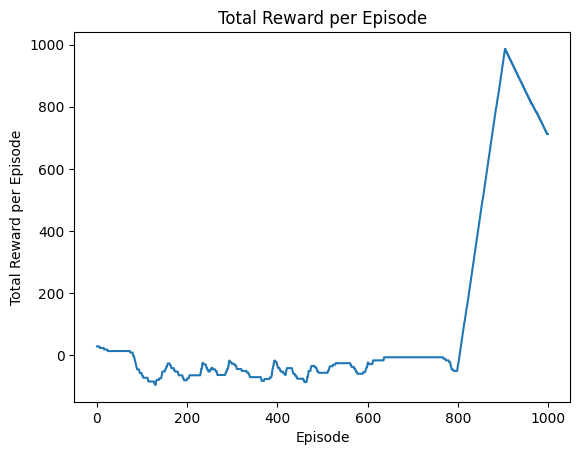

In [96]:

for gamma in hp_gamma_values:
    for epsilon_decay in hp_epsilon_decay_values:
        print(f"\nGamma: {gamma}, Epsilon Decay: {epsilon_decay}")
        # definign the agent 
        agent = SARSAAgent(env, gamma=gamma, epsilon_decay=epsilon_decay)
        # executing the sarsa function 
        q_table  = sarsa_execution(env, agent, num_episodes=1000)
        # trained q table is 
        print("Trained Q-table:")
        for state, actions in q_table.items():
            print(f"State {state}: {actions}")
        # Plotting the total reward per episode graph
        plot_rewards(agent.total_rewards)
